In [1]:
import copy
import collections
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolAlign
from rdkit.Chem import PeriodicTable
from rdkit.Chem.Lipinski import RotatableBondSmarts
import scipy
from scipy import spatial as sci_spatial
import torch
from tqdm.auto import tqdm
import sys
sys.path.append('../')

ptable = Chem.GetPeriodicTable()

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  


## Load Data

In [2]:
from eval_utils import ModelResults

result_dir = '../samples'

ref_path = os.path.join(result_dir, 'crossdocked_test_vina_docked.pt')
ar_path = os.path.join(result_dir, 'ar_vina_docked.pt')
tg_path = os.path.join(result_dir, 'targetdiff_vina_docked.pt')
vf_path = os.path.join(result_dir, 'vfdiff3_vina_docked.pt')
ip_path = os.path.join(result_dir, 'ipdiff_vina_docked.pt')
p2m_path = os.path.join(result_dir, 'pocket2mol_vina_docked.pt')
flag_path = os.path.join(result_dir, 'flag_vina_docked.pt')
dcmp_ref_path = os.path.join(result_dir, 'decompdiff_ref_vina_docked.pt')


ref = ModelResults('Reference', ref_path)
ar = ModelResults('AR', ar_path)
p2m = ModelResults('Pocket2Mol', p2m_path)
flag = ModelResults('FLAG', flag_path)
tg = ModelResults('TargetDiff', tg_path)
vf = ModelResults('VFDiff', vf_path)
ip = ModelResults('IPDiff', ip_path)
dcmp_ref = ModelResults('DecompDiff-R', dcmp_ref_path)


models = [ref,tg,vf,ip,dcmp_ref,ar,p2m,flag]
for model in models:
    if model not in (vf,ip):
        model.load_pose_checked()
    else:
        model.load_pose_checked_v()

Reference loaded 100 pose checked results
TargetDiff loaded 9036 pose checked results
VFDiff loaded 9367 pose checked results
IPDiff loaded 9252 pose checked results
DecompDiff-R loaded 8292 pose checked results
AR loaded 9295 pose checked results
Pocket2Mol loaded 9831 pose checked results
FLAG loaded 9863 pose checked results


## Distance & Bond Length

(6, 6, 1), #	CC	716	29.6%	1.2857153558712793	1.696778883283098	0.004110635274118186
(6, 6, 4), #	C:C	500	20.7%	1.2981754588686738	1.5429516779717267	0.002447762191030529
(6, 8, 1), #	CO	336	13.9%	1.217717567891834	1.592581263775381	0.0037486369588354694
(6, 7, 1), #	CN	245	10.1%	1.2412786652760066	1.609101379383609	0.0036782271410760246
(6, 7, 4), #	C:N	213	8.8%	1.2781037555594505	1.4881754271876604	0.002100716716282098
(8, 15, 1), #	OP	110	4.5%	1.4386686273997809	1.6660045479020018	0.0022733592050222097
(6, 8, 2), #	C=O	101	4.2%	1.1665386961880702	1.4203634176470261	0.0025382472145895596


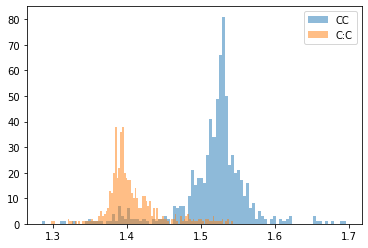

In [3]:
from core.evaluation.utils import eval_bond_length

bond_lengths = []
for res in ref.flat_results:
    mol = res['mol']
    mol = Chem.RemoveAllHs(mol)
    bond_lengths += eval_bond_length.bond_distance_from_mol(mol)

profile = eval_bond_length.get_bond_lengths(bond_lengths)

N_BINS = 100

# plt.hist(ref.all_c_c_distance, bins=N_BINS, label='all c c pairs', alpha=0.5)

allowed_bond_types = []
for k, v in sorted(profile.items(), key=lambda x: len(x[1]), reverse=True):
    freq = len(v)
    rate = freq / len(bond_lengths) * 100
    if freq < 10:
        continue

    if freq > 100:
        allowed_bond_types.append(k)
        bond_type_str = eval_bond_length._bond_type_str(k)
        if k[0] == k[1] == 6:
            plt.hist(profile[k], bins=N_BINS, label=bond_type_str, alpha=0.5)
        min_val, max_val = np.min(profile[k]), np.max(profile[k])
        bin_width = (max_val - min_val) / N_BINS
        print(f'{k}, #\t{bond_type_str}\t{freq}\t{rate:.1f}%\t{min_val}\t{max_val}\t{bin_width}')

plt.legend()
plt.show()

In [4]:
profiles = []

ref_profile = profile
N_BINS = 100

for model in models:
    bond_lengths = []
    for res in model.flat_results:
        mol = res['mol']
        mol = Chem.RemoveAllHs(mol)
        bond_lengths += eval_bond_length.bond_distance_from_mol(mol)
    profiles.append(eval_bond_length.get_bond_lengths(bond_lengths))


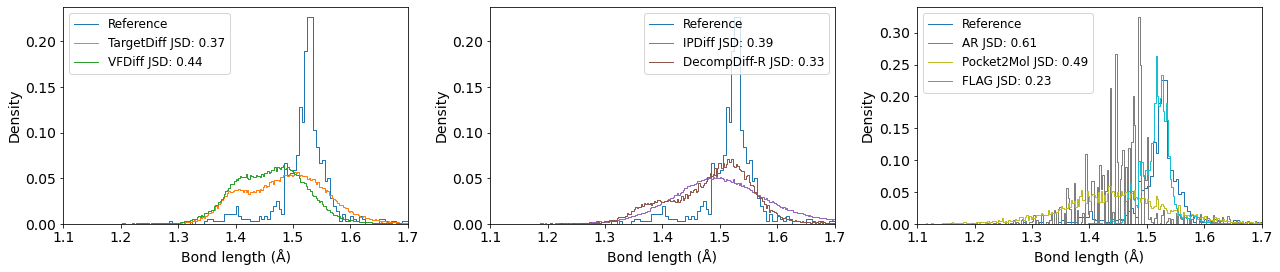

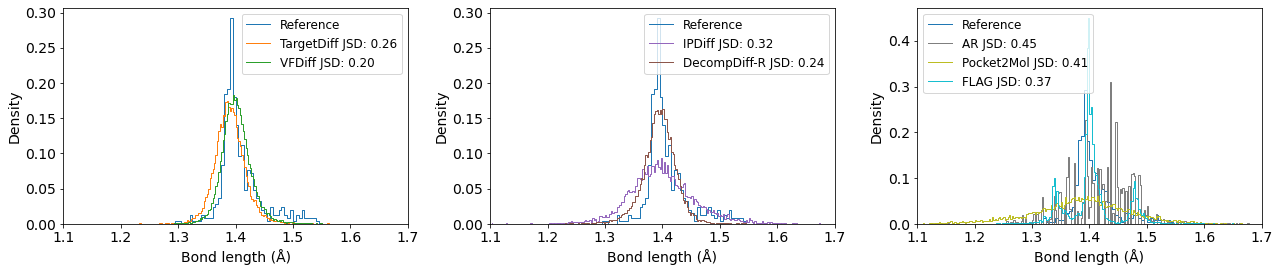

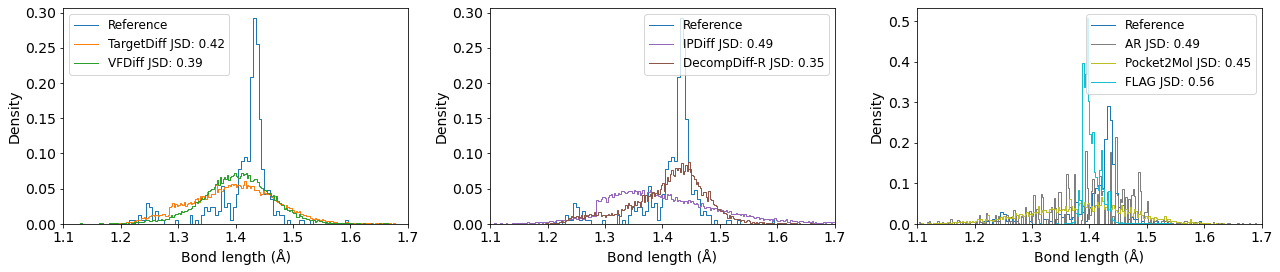

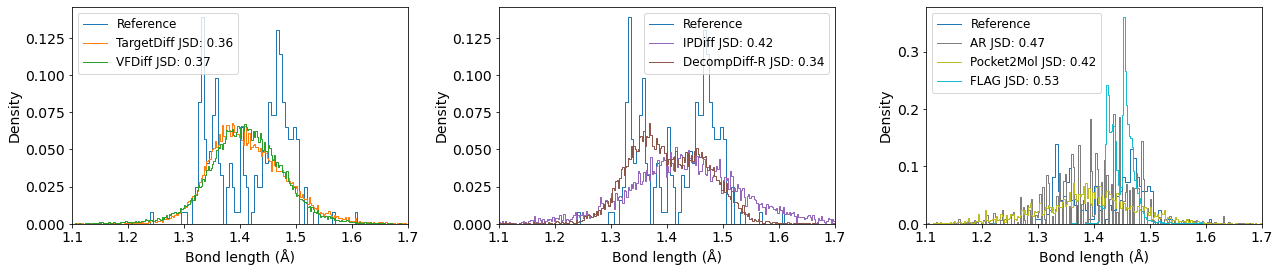

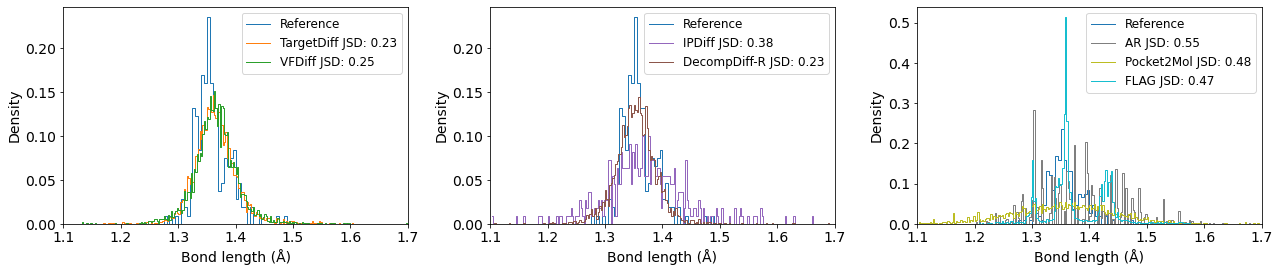

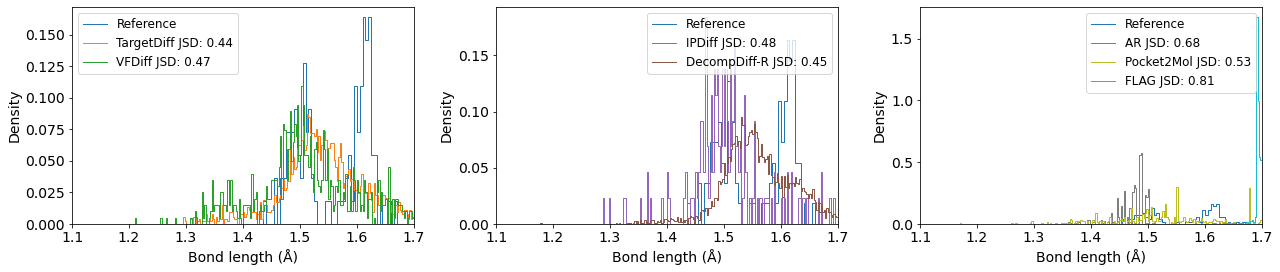

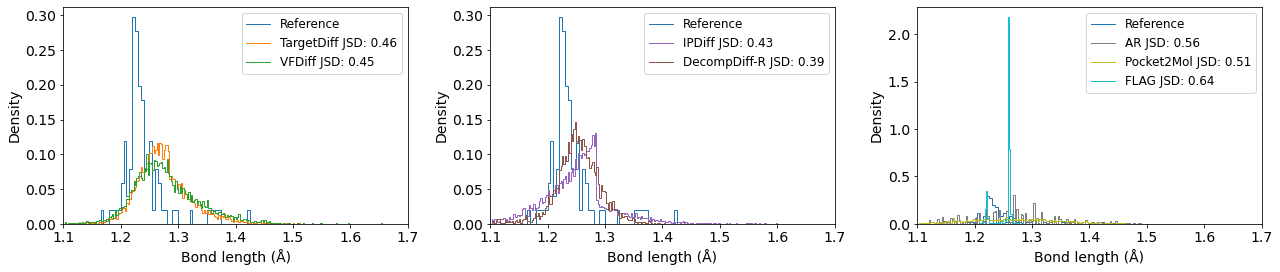

In [5]:
from scipy import spatial as sci_spatial
import seaborn as sns

BOND_LENGTH_BINS = np.arange(1.1, 1.70001, 0.005)
BOND_LENGTH_BINS_2 = np.arange(1.1, 1.70001, 0.0025)
# BOND_RANGE = (1.1, 1.7)
colors = ['tab:gray', 'tab:green', 'tab:olive', 'tab:red', 'tab:orange', 'tab:pink', 'tab:blue', 'tab:cyan', 'tab:purple', 'tab:gray', 'tab:brown'] 

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# set matplotlib font size to a larger one
plt.rcParams.update({'font.size': 14})
# set legend font size smaller
plt.rcParams.update({
    'legend.fontsize': '12',
    # 'legend.handlelength': 2
})

group1 = [tg, vf]#[ar, p2m, flag]
group2 = [ ip, dcmp_ref]
group3 = [ar,p2m,flag]#[molcraft]
# [ref,tg,vf,ip,dcmp_ref,ar,p2m,flag]
BOND = (6, 7, 1)
LINE_WIDTH = 1
for BOND in allowed_bond_types:
    ref_dist = np.histogram(ref_profile[BOND], bins=BOND_LENGTH_BINS, density=True)[0] / 100

    plt.figure(figsize=(6*3, 4))
    plt.subplot(1, 3, 1)
    plt.step(BOND_LENGTH_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group1):
        model_dist = np.histogram(profiles[idx + 1][BOND], bins=BOND_LENGTH_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[idx + 1][BOND], bins=BOND_LENGTH_BINS_2, density=True)[0] / 100
        plt.step(BOND_LENGTH_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name} JSD: {jsd:.2f}', color=colors[idx+1])
    plt.xlabel('Bond length (Å)')
    plt.ylabel('Density')
    plt.legend()
    plt.xlim(1.1, 1.7)
    plt.ylim(0)
    plt.tight_layout()

    plt.subplot(1, 3, 2)
    plt.step(BOND_LENGTH_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group2):
        model_dist = np.histogram(profiles[idx + 3][BOND], bins=BOND_LENGTH_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[idx + 3][BOND], bins=BOND_LENGTH_BINS_2, density=True)[0] / 100
        plt.step(BOND_LENGTH_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name} JSD: {jsd:.2f}', color=colors[idx+4])
    plt.xlabel('Bond length (Å)')
    plt.ylabel('Density')
    # set legend to upper right
    plt.legend(loc='upper right')
    plt.xlim(1.1, 1.7)
    plt.ylim(0)
    plt.tight_layout()

    plt.subplot(1, 3, 3)
    plt.step(BOND_LENGTH_BINS[1:], ref_dist, linewidth=LINE_WIDTH, label='Reference', color=colors[0])
    for idx, model in enumerate(group3):
        model_dist = np.histogram(profiles[idx + 5][BOND], bins=BOND_LENGTH_BINS, density=True)[0] / 100
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        model_dist = np.histogram(profiles[idx + 5][BOND], bins=BOND_LENGTH_BINS_2, density=True)[0] / 100
        plt.step(BOND_LENGTH_BINS_2[1:], model_dist, linewidth=LINE_WIDTH, label=f'{model.name} JSD: {jsd:.2f}', color=colors[idx+7])
    plt.xlabel('Bond length (Å)')
    plt.ylabel('Density')
    plt.legend()
    plt.xlim(1.1, 1.7)
    plt.ylim(0)
    plt.tight_layout()
    #plt.savefig(f'./figs/{eval_bond_length._bond_type_str(BOND)}_length.pdf', dpi=300, bbox_inches='tight')
    plt.show()

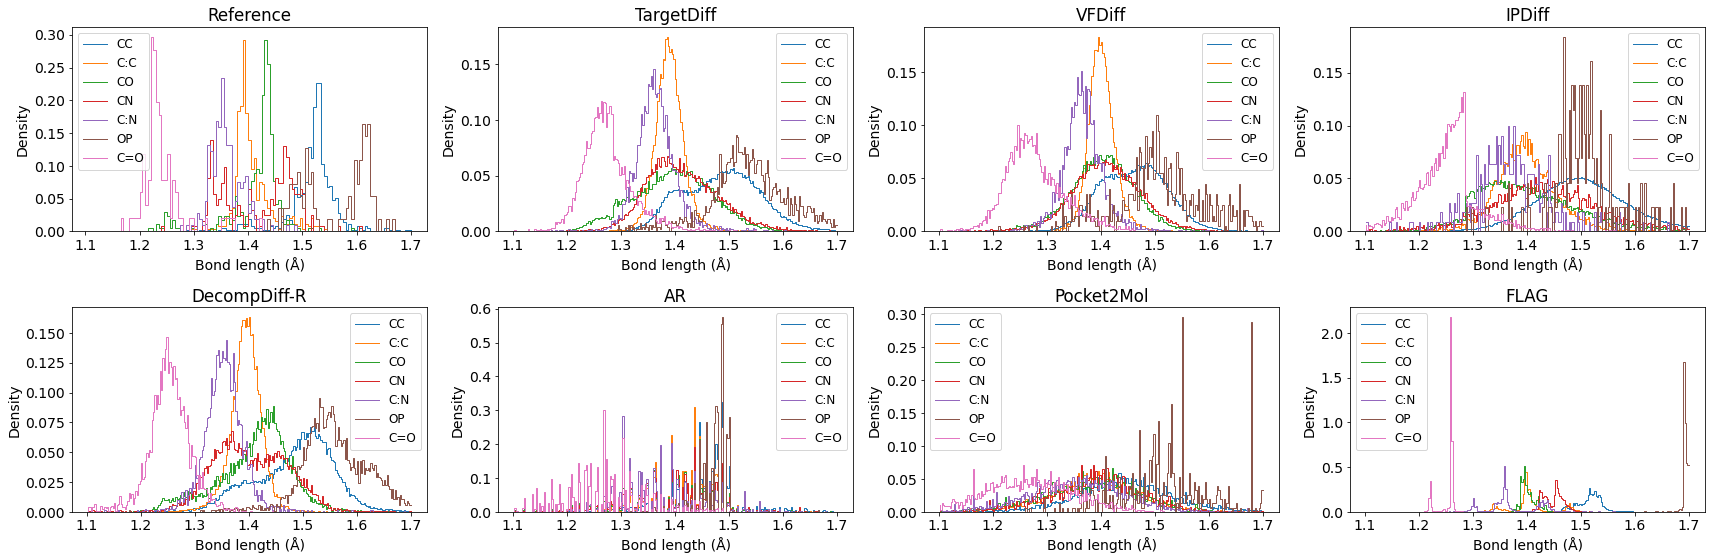

In [6]:
BINS = np.arange(1.1, 1.70001, 0.005)
BINS2 = np.arange(1.1, 1.70001, 0.0025)

# set matplotlib font size to a larger one
plt.rcParams.update({'font.size': 14})
# set legend font size smaller
plt.rcParams.update({
    'legend.fontsize': '12',
    # 'legend.handlelength': 2
})

plt.figure(figsize=(6*4, 4*2))
for idx, model in enumerate(models):
    plt.subplot(2, 4, idx+1)
    if idx == 0:
        bins = BINS
    else:
        bins = BINS2
    for BOND in allowed_bond_types:
        model_dist = np.histogram(profiles[idx][BOND], bins=bins, density=True)[0] / 100
        plt.step(bins[1:], model_dist, linewidth=1, label=f'{eval_bond_length._bond_type_str(BOND)}')
    plt.xlabel('Bond length (Å)')
    plt.ylabel('Density')
    plt.ylim(0)
    plt.legend()
    plt.tight_layout()
    plt.title(model.name)
# plt.savefig(f'figs/all_length.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Bond Angle

(6, 1, 6, 1, 6), #	CCC	521	18.1%	59.52230720788234	135.50315793532704	0.759808507274447
(6, 4, 6, 4, 6), #	C:C:C	460	16.0%	101.54806405949785	127.54928623790771	0.2600122217840986
(6, 1, 6, 1, 8), #	CCO	274	9.5%	57.19735111082594	136.5409407542893	0.7934358964346336
(6, 4, 6, 4, 7), #	C:C:N	165	5.7%	104.22596576259151	137.30565369110124	0.33079687928509727
(6, 1, 6, 1, 7), #	CCN	145	5.0%	60.72412083990659	130.82160994747824	0.7009748910757164


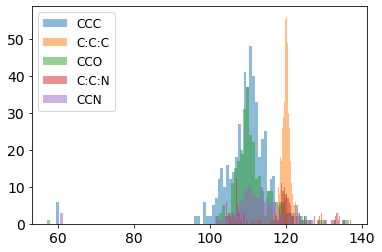

In [7]:
from core.evaluation.utils import eval_bond_angle

bond_angles = []
for res in ref.flat_results:
    mol = res['mol']
    mol = Chem.RemoveAllHs(mol)
    bond_angles += eval_bond_angle.bond_angle_from_mol(mol)

profile = eval_bond_angle.get_bond_angles(bond_angles)

N_BINS = 100

allowed_angle_types = []
for k, v in sorted(profile.items(), key=lambda x: len(x[1]), reverse=True):
    freq = len(v)
    rate = freq / len(bond_angles) * 100
    if freq < 70: # 10
        continue

    if freq > 130: 
        allowed_angle_types.append(k)
        angle_type_str = eval_bond_angle._angle_type_str(k)
        plt.hist(profile[k], bins=N_BINS, label=angle_type_str, alpha=0.5)
        min_val, max_val = np.min(profile[k]), np.max(profile[k])
        bin_width = (max_val - min_val) / N_BINS
        print(f'{k}, #\t{angle_type_str}\t{freq}\t{rate:.1f}%\t{min_val}\t{max_val}\t{bin_width}')
plt.legend()
plt.show()

In [8]:
# import counter
from collections import Counter

ref_profile = profile
profiles = []

error_models = []
for model in models:
    bond_angles = []
    for res in model.flat_results:
        mol = res['mol']
        mol = Chem.RemoveAllHs(mol)
        try:
            bond_angles += eval_bond_angle.bond_angle_from_mol(mol)
        except:
            error_models.append(model)
    profiles.append(eval_bond_angle.get_bond_angle_profile(bond_angles))

# error_models = Counter(error_models)
# print(error_models)
#type(profiles[1])

eval_bond_angle.eval_bond_angle_profile(profiles[0],profiles[2])

atoms j and k have identical 3D coordinates
Error in bond angle calculation
atoms i and j have identical 3D coordinates
Error in bond angle calculation
atoms i and j have identical 3D coordinates
Error in bond angle calculation
atoms i and j have identical 3D coordinates
Error in bond angle calculation
atoms j and k have identical 3D coordinates
Error in bond angle calculation
atoms j and k have identical 3D coordinates
Error in bond angle calculation
atoms i and j have identical 3D coordinates
Error in bond angle calculation
atoms i and j have identical 3D coordinates
Error in bond angle calculation
atoms i and j have identical 3D coordinates
Error in bond angle calculation
atoms i and j have identical 3D coordinates
Error in bond angle calculation
atoms j and k have identical 3D coordinates
Error in bond angle calculation
atoms j and k have identical 3D coordinates
Error in bond angle calculation
atoms i and j have identical 3D coordinates
Error in bond angle calculation
atoms i and 

{'JSD_C:C:N': 0.4473801498970884,
 'JSD_CCN': 0.43274494352466714,
 'JSD_C:C:C': 0.24787718866662983,
 'JSD_CCC': 0.3992534615611787,
 'JSD_CCO': 0.4726596175296222}